## Paso 0: Preparación del entorno

#### Importar librerías

In [21]:
#print "IMPORTING LIBRARIES..."
import pandas as pd
import numpy as np
import math
import statsmodels.api as sm
import matplotlib.pyplot as plt
import re
import requests
from scipy import stats
from requests.auth import HTTPBasicAuth

%matplotlib inline

In [22]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import AdaBoostClassifier

#### Descargar ficheros

In [23]:
#DOWLOADING FILE FROM DROPBOX FIRST TIME
import urllib2
import os.path
import time
import random

while not os.path.exists('dev.csv') or not os.path.exists('oot0.csv'):
    time.sleep (3*random.random()); #Sleeping less than 3 seconds before going to Dropbox - avoid too many students at once.
    if not os.path.exists('dev.csv'):
        print "DOWLOADING FILE dev.csv FROM DROPBOX BECAUSE LOCAL FILE DOES NOT EXIST!"
        csvfile = urllib2.urlopen("https://dl.dropboxusercontent.com/u/28535341/dev.csv")
        output = open('dev.csv','wb')
        output.write(csvfile.read())
        output.close()
    if not os.path.exists('oot0.csv'):
        print "DOWLOADING FILE oot0.csv FROM DROPBOX BECAUSE LOCAL FILE DOES NOT EXIST!"
        csvfile = urllib2.urlopen("https://dl.dropboxusercontent.com/u/28535341/oot0.csv")
        output = open('oot0.csv','wb')
        output.write(csvfile.read())
        output.close()  
#DOWLOADING FILE FROM DROPBOX FIRST TIME

#### Cargar ficheros

In [29]:
print "LOADING DATASETS..."
df = pd.read_csv("../dev.csv") #DEV-SAMPLE
dfo = pd.read_csv("../oot0.csv") #OUT-OF-TIME SAMPLE

LOADING DATASETS...


In [ ]:
df.describe()

In [ ]:
dfo.describe()

#### Identificar tipos de datos

In [30]:
print "IDENTIFYING TYPES..."
in_model = []
list_ib = set()  #input binary
list_icn = set() #input categorical nominal
list_ico = set() #input categorical ordinal
list_if = set()  #input numerical continuos (input float)
list_inputs = set()
output_var = 'ob_target' # result used later
for var_name in df.columns:
    if re.search('^i',var_name) and var_name<>'id':
        list_inputs.add(var_name)
        #print var_name,"is input"   
    if re.search('^ib_',var_name):
        list_ib.add(var_name)
        #print var_name,"is input binary"
    elif re.search('^icn_',var_name):
        list_icn.add(var_name)
        #print var_name,"is input categorical nominal"
    elif re.search('^ico_',var_name):
        list_ico.add(var_name)
        #print var_name,"is input categorical ordinal"
    elif re.search('^if_',var_name):
        list_if.add(var_name)
        #print var_name,"is input numerical continuos (input float)"
    elif re.search('^ob_',var_name):
        output_var = var_name
    else:
        print "ERROR: unable to identify the type of:", var_name

IDENTIFYING TYPES...
ERROR: unable to identify the type of: id


## Paso 1: Transformaciones

In [26]:
print "STEP 1: DOING MY TRANSFORMATIONS..."


STEP 1: DOING MY TRANSFORMATIONS...


#### Transforming NaN values

In [31]:
def variablesNaN(data, features):
    result = pd.DataFrame(index = ['NaN'], columns = features)
    for var_name in features:
        if data[var_name].isnull().any() == True:
            result[var_name] = True
    
    return result

# Dev
df_nan = variablesNaN(df, list_inputs)
df_nan.dropna(axis=1).columns

# OoT
dfo_nan = variablesNaN(dfo, list_inputs)
dfo_nan = dfo_nan.dropna(axis=1).columns
dfo_nan

Index([u'ico_var_33', u'ico_var_37', u'ib_var_21', u'ib_var_20', u'ib_var_18',
       u'ib_var_19', u'ib_var_15', u'ib_var_16', u'ib_var_17', u'ico_var_26',
       u'if_var_78', u'icn_var_22', u'icn_var_24'],
      dtype='object')

In [32]:
for var in list_inputs:
    if dfo[var].isnull().any() == True:
        if var in list_ib:
            #dfo['ib_var_18'].median()
            #mode_var = stats.mode(dfo[var])
            #dfo[var] = dfo[var].fillna(mode_var[0].item(0))
            dfo[var] = dfo[var].fillna(-1)
        if var in list_ico:
            dfo[var] = dfo[var].fillna(dfo[var].median())
        if var in list_icn:
            dfo[var] = dfo[var].fillna(dfo[var].median())
        if var in list_if:
            mode_var = stats.mode(dfo[var])
            dfo[var] = dfo[var].fillna(mode_var[0].item(0))
            #dfo[var] = dfo[var].fillna(dfo[var].median())
        

In [ ]:
# VARIABLES NUMERICAS
np.isnan(dfo["if_var_78"]).unique()
dfo["if_var_78"] = dfo["if_var_78"].fillna(dfo["if_var_78"].mean())

# VARIABLES CATEGORICAS
np.isnan(dfo['ico_var_33']).unique()
dfo['ico_var_33'] = dfo['ico_var_33'].fillna(dfo['ico_var_33'].median())
#mode_var33 = stats.mode(dfo['ico_var_33'])
#dfo['ico_var_33'] = dfo['ico_var_33'].fillna(mode_var33[0].item(0))
#dfo['ico_var_33'] = dfo['ico_var_33'].fillna(dfo['ico_var_33'].max())

np.isnan(dfo['ico_var_26']).unique()
dfo['ico_var_26'] = dfo['ico_var_26'].fillna(dfo['ico_var_26'].median())

np.isnan(dfo['ico_var_37']).unique()
dfo['ico_var_37'] = dfo['ico_var_37'].fillna(dfo['ico_var_37'].median())

np.isnan(dfo['icn_var_22']).unique()
dfo['icn_var_22'] = dfo['icn_var_22'].fillna(dfo['icn_var_22'].median())

np.isnan(dfo['icn_var_24']).unique()
dfo['icn_var_24'] = dfo['icn_var_24'].fillna(dfo['icn_var_24'].median())

# VARIABLES BINARIAS
np.isnan(dfo['ib_var_20']).unique()
#dfo['ib_var_20'].median()
mode_var20 = stats.mode(dfo['ib_var_20'])
dfo['ib_var_20'] = dfo['ib_var_20'].fillna(mode_var20[0].item(0))

np.isnan(dfo['ib_var_19']).unique()
#dfo['ib_var_19'].median()
mode_var19 = stats.mode(dfo['ib_var_19'])
dfo['ib_var_19'] = dfo['ib_var_19'].fillna(mode_var19[0].item(0))

np.isnan(dfo['ib_var_16']).unique()
#dfo['ib_var_16'].median()
mode_var16 = stats.mode(dfo['ib_var_16'])
dfo['ib_var_16'] = dfo['ib_var_16'].fillna(mode_var16[0].item(0))

## Paso 2: Selección de variables

#### WoE and Information Value

|Information Value|	Predictive Power|
| ---------- | ---------- |
|< 0.02|	useless for prediction|
|0.02 to 0.1|	Weak predictor|
|0.1 to 0.3|	Medium predictor|
|0.3 to 0.5|	Strong predictor|
 |>0.5|	Suspicious or too good to be true|

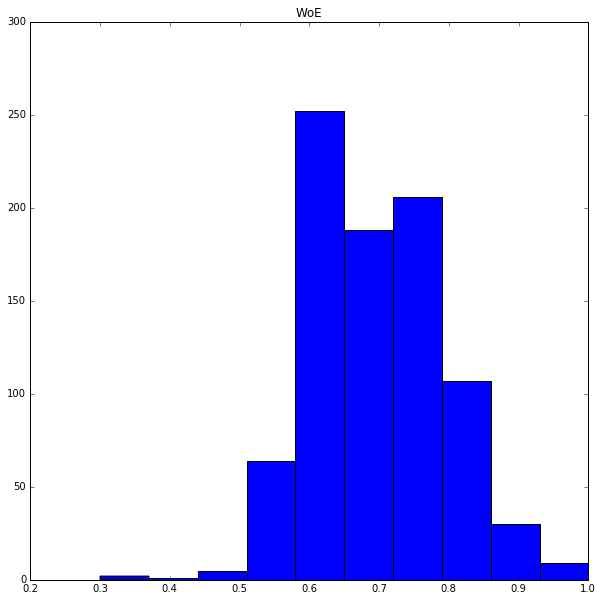

,if_var_70,if_var_81,if_var_73,ico_var_33,if_var_71,ico_var_37,ico_var_36,ico_var_35,ico_var_34,ib_var_20,...,ib_var_8,ib_var_5,ib_var_2,if_var_65,ib_var_1,ico_var_59,if_var_69,icn_var_22,ico_var_48,icn_var_24
IV,0.035218,0.046819,0.270286,0.158278,0.078671,0.041395,0.196236,0.146473,0.11338,0.053014,...,0.024402,0.051462,0.023865,0.445769,0.028604,0.051911,0.371181,0.031246,0.030484,0.022375


In [33]:
def calculateIV(data, cols, out_var):
    features = list(cols)
    result_iv = pd.DataFrame(index = ['IV'], columns = features)
       
    for var_name in cols:
        biv = pd.crosstab(data[var_name],data[out_var])
        a= 0.01 # to avoid division by zero
        WoE = np.log((1.0*biv[0]/sum(biv[0])+a) / (1.0*biv[1]/sum(biv[1])+a))
        #print WoE
        IV = sum(((1.0*biv[0]/sum(biv[0])+a) - (1.0*biv[1]/sum(biv[1])+a))*np.log((1.0*biv[0]/sum(biv[0])+a) / (1.0*biv[1]/sum(biv[1])+a)))
        result_iv[var_name] = IV

    return result_iv

df_iv = calculateIV(df, list_inputs, output_var)
df_var = df_iv[(df_iv>=0.02)].dropna(axis=1)


# Plot the feature importances of the forest
plt.figure(figsize=(10,10))
plt.title("WoE")
plt.hist(df['if_var_80'])
plt.show()

df_var

#### Seleccionar variables para el modelo

Selecciono las variables que tienen un Information Value mayor que 0.1.

In [34]:
print "SELECTING CHARACTERISTICS TO ENTER INTO THE MODEL..."

#in_model = list_inputs #['ib_var_1','icn_var_22','ico_var_25','if_var_65']

in_model = df_var.columns

in_model

SELECTING CHARACTERISTICS TO ENTER INTO THE MODEL...


Index([u'if_var_70', u'if_var_81', u'if_var_73', u'ico_var_33', u'if_var_71',
       u'ico_var_37', u'ico_var_36', u'ico_var_35', u'ico_var_34',
       u'ib_var_20', u'ico_var_31', u'ico_var_30', u'if_var_67', u'if_var_68',
       u'ico_var_39', u'ico_var_50', u'ico_var_53', u'ico_var_52',
       u'ico_var_55', u'ico_var_56', u'ico_var_32', u'if_var_80',
       u'ico_var_61', u'if_var_79', u'ico_var_64', u'ico_var_45', u'ib_var_16',
       u'if_var_76', u'if_var_77', u'if_var_74', u'if_var_75', u'if_var_72',
       u'ico_var_25', u'ico_var_26', u'ico_var_27', u'ico_var_28',
       u'if_var_78', u'ico_var_47', u'ico_var_42', u'ico_var_43',
       u'ico_var_41', u'ico_var_44', u'ib_var_8', u'ib_var_5', u'ib_var_2',
       u'if_var_65', u'ib_var_1', u'ico_var_59', u'if_var_69', u'icn_var_22',
       u'ico_var_48', u'icn_var_24'],
      dtype='object')

## Paso 3: Desarrollo del modelo

In [35]:
print "STEP 3: DEVELOPING THE MODEL..."

# Filtrado de variables

X = df[list(set(in_model))]
y = df[output_var]
Xo = dfo[list(set(in_model))]


STEP 3: DEVELOPING THE MODEL...


#### Modelo 1

In [39]:
cutoff = 0.8

clf = RandomForestClassifier(n_estimators=7000, 
                             min_weight_fraction_leaf=0.00000000001,
                             #class_weight={0: cutoff, 1: (1-cutoff)},
                             class_weight='balanced',
                             criterion='entropy')
model = clf.fit(X,y)


#### Modelo 2

In [ ]:
clf = AdaBoostClassifier(n_estimators=7000)

model = clf.fit(X,y)

#### Predicción

In [40]:
try:
    y_pred  = model.predict_proba(X)
    y_pred = y_pred[:,1]
    yo_pred = model.predict_proba(Xo)
    yo_pred = yo_pred[:,1]    
    
except np.linalg.linalg.LinAlgError as err:
    if 'Singular matrix' in err.message:
        print "MODEL-INVALID (Singular Matrix)"
    else:
        raise


## Paso 4: Enviar resultados

In [41]:
print "STEP 4: ASSESSING THE MODEL..."
# CALCULATING GINI PERFORMANCE ON DEVELOPMENT SAMPLE
from sklearn.metrics import roc_auc_score
gini_score = 2*roc_auc_score(df[output_var], y_pred)-1
print "GINI DEVELOPMENT=", gini_score

print "STEP 5: SUBMITTING THE RESULTS..."
dfo['pred'] = yo_pred
dfo_tosend = dfo[list(['id','pred'])]

i=2
filename = "group_Z_sub"+str(i)+".csv"
dfo_tosend.to_csv(filename, sep=',')

url = 'http://mgadi.pythonanywhere.com/api/v1.0/uploadpredictions'

files = {'file': (filename, open(filename, 'rb'))}
rsub = requests.post(url, files=files, auth=HTTPBasicAuth('josegonzalez', 'levante'))
resp_str = str(rsub.text)
print "RESULT SUBMISSION: ", resp_str


STEP 4: ASSESSING THE MODEL...
GINI DEVELOPMENT= 1.0
STEP 5: SUBMITTING THE RESULTS...
RESULT SUBMISSION:  KS2 = 0.380850237615; GINI = 0.528449120731
